In [2]:
import pandas as pd
import numpy as np
import torch
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

import fastai
from fastai.imports import *
from fastai.torch_imports import *
from fastai.core import *
from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.text import *

import dill as pickle
!pip install spacy
!python -m spacy download en
import spacy
import html

import pickle
import collections
import math
!pip install nbimporter
import nbimporter

    100% |████████████████████████████████| 496.4MB 29.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0
    100% |████████████████████████████████| 122kB 8.4MB/s 
    100% |████████████████████████████████| 3.6MB 9.5MB/s 
    100% |████████████████████████████████| 1.5MB 18.9MB/s 
    100% |████████████████████████████████| 184kB 22.8MB/s 
    100% |████████████████████████████████| 61kB 23.5MB/s 
    100% |████████████████████████████████| 12.5MB 3.9MB/s 
    100% |████████████████████████████████| 102kB 30.1MB/s 
    100% |████████████████████████████████| 81kB 30.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/whe


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
## DATA CLEANING AND TOKENIZATION

# define paths and load data
clas_path  = Path('model_extension_parameters/fine_tuning_big_dataset/clas')
lm_path    = Path('model_extension_parameters/fine_tuning_big_dataset/lm')
total_data = pd.read_csv('datasets/sentiment140.csv', encoding = 'latin-1', 
                         header = None, names = ["target", "id", "date", "flag", "user", "text"])

np.random.seed(39)
rndm_idx     = np.random.permutation(len(total_data))
rndm_idx_lim = rndm_idx[0:300000]
my_data      = total_data.iloc[rndm_idx_lim,]

y = my_data.target
x = my_data.text

## classification
# create training and validation sets
trn_texts,val_texts, trn_labels, val_labels = sklearn.model_selection.train_test_split(
                                              x, y, test_size = 0.2,
                                              random_state = 41)

trn_texts  = np.array(trn_texts)
trn_labels = np.array(trn_labels)
val_texts  = np.array(val_texts)
val_labels = np.array(val_labels)


# randomize order
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))


# reorder texts
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]


# reorder labels 
trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]


# create dataframe
col_names = ['labels','text']
df_trn    = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, 
                         columns = col_names)
df_val    = pd.DataFrame({'text':val_texts, 'labels':val_labels}, 
                         columns = col_names)


# save training and validation dataset
classes = ['Positive', 'Negative', 'Neutral']
df_trn.to_csv(clas_path/'train.csv', header = False, index = False)
df_val.to_csv(clas_path/'test.csv', header = False, index = False)
(clas_path/'classes.txt').open('w').writelines(f'{o}\n' for o in classes)


## language model
# create training and validation sets
trn_texts, val_texts = sklearn.model_selection.train_test_split(
                       np.concatenate([trn_texts,val_texts]), test_size = 0.1,
                       random_state = 43)


# saving training and validation dataset
df_trn = pd.DataFrame({'text':trn_texts, 'labels':
                       [0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':
                       [0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(lm_path/'train.csv', header=False, index=False)
df_val.to_csv(lm_path/'test.csv', header=False, index=False)

In [5]:
from functions import Prep

# tokenization
chunksize = 24000
BOS = 'xbos'  # beginning-of-sentence tag
df_trn = pd.read_csv(lm_path/'train.csv', header = None, 
                     chunksize = chunksize)
df_val = pd.read_csv(lm_path/'test.csv', header = None, 
                     chunksize = chunksize)

tok_trn, trn_labels = Prep.get_all(df_trn, 1)
tok_val, val_labels = Prep.get_all(df_val, 1)

# save tokenization
np.save(lm_path/'tok_trn.npy', tok_trn)
np.save(lm_path/'tok_val.npy', tok_val)

0
1
2
3
4
5
6
7
8
9
10
11
0
1


In [0]:
# limit vocabulary
max_vocab = 60000
min_freq  = 2

freq = Counter(p for o in tok_trn for p in o)


# create translation from integer to string and string to integer
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')

stoi = collections.defaultdict(lambda:0, 
                               {v:k for k,v in enumerate(itos)})


# tweets expressed as integers
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])


# save dictionary
np.save(lm_path/'trn_ids.npy', trn_lm)
np.save(lm_path/'val_ids.npy', val_lm)
pickle.dump(itos, open(lm_path/'itos.pkl', 'wb'))

In [0]:
## PRETRAINED LANGUAGE MODEL

# set model parameters
em_sz, nh, nl = 400, 1150, 3


# load itos and stoi from the pretrained Wikitext-103 language model
with open('wt103/itos_wt103.pkl', 'rb') as pickle_file:
    itos_wiki = pickle.load(pickle_file)
    
stoi_wiki = collections.defaultdict(lambda:-1, {v:k for k,v 
                                              in enumerate(itos_wiki)})


# load model weights from the pretrained Wikitext-103 language model
lm_wgts_wiki = torch.load('wt103/fwd_wt103.h5', 
                          map_location = lambda storage, loc: storage)


# match tokens between the two vocabularies
enc_wgts     = lm_wgts_wiki['0.encoder.weight'].numpy()
row_m        = np.mean(enc_wgts, axis = 0)

new_wm = np.zeros((len(itos), em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r         = stoi_wiki[w]
    new_wm[i] = enc_wgts[r] if r>=0 else row_m

lm_wgts_wiki['0.encoder.weight'] = T(new_wm)
lm_wgts_wiki['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wm))
lm_wgts_wiki['1.decoder.weight'] = T(np.copy(new_wm))

In [0]:
wd   = 1e-7
bptt = 70
bs   = 64
t    = len(np.concatenate(trn_lm))


# define optimizer and create data loader 
opt_fn  = partial(optim.Adam, betas = (0.8, 0.99))
trn_dl  = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl  = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In [0]:
## CREATE MODEL ARCHITECTURE


md = LanguageModelData('model_extension_parameters/fine_tuning_big_dataset', pad_idx = 1, n_tok = len(itos), trn_dl = trn_dl, val_dl = val_dl, bs = bs, 
                       bptt = bptt)


# define droupout parameters and create model architecture
drops   = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
          dropouti = drops[0], dropout = drops[1], wdrop = drops[2],
          dropoute = drops[3], dropouth = drops[4])


learner.metrics = [accuracy]
learner.freeze_to(-1)

In [13]:
# load model weights from pretrained wikipedia model
learner.model.load_state_dict(lm_wgts_wiki)


# set initial learning rate
lr  = 1e-3


# fit model with frozen lstm for one epoch
learner.fit(lr, 1, wds = wd, use_clr = (32,2), cycle_len = 1) 

epoch      trn_loss   val_loss   accuracy   
    0      4.951483   4.677041   0.239547  



[array([4.67704]), 0.23954705898727374]

 76%|███████▋  | 834/1091 [10:36<02:41,  1.60it/s, loss=18.9]

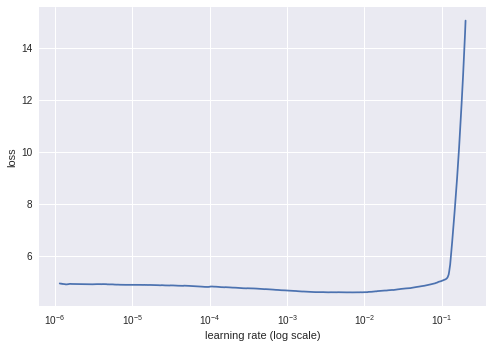

In [14]:
# save learner for further training
learner.save('lm_last_ft')


# unfreeze all layers
learner.unfreeze()


# perform and plot algorithm to find optimal learning rate
learner.lr_find(lr/1000)
learner.sched.plot()

In [10]:
learner.load('lm_last_ft')


# set discriminative learning rate
lr  = 1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])


# fit model with unfrozen lstm layers until it overfits
learner.fit(lrs, 1, wds = wd, use_clr = (20,10), cycle_len = 3)

epoch      trn_loss   val_loss   accuracy   
    0      4.644789   4.396335   0.262055  
    1      4.511829   4.339592   0.265968  
    2      4.424206   4.312373   0.268478  



[array([4.31237]), 0.2684778152205651]

In [0]:
learner.sched.plot_loss()

In [0]:
# save complete model and encoder
learner.save('lmbig')